<a href="https://colab.research.google.com/github/TejasUpadhyayy/Retinad/blob/main/retinad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
import os

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import EfficientNetB0

# Data preprocessing and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

# For math operations
import math


In [ ]:
# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Define the base path to your data in Google Drive
base_path = '/content/drive/My Drive/IDRiD'  # Update 'IDRiD' if your data folder has a different name

# Load training data
train_images = np.load(f'{base_path}/processed_training/images.npy')
train_dr_labels = np.load(f'{base_path}/processed_training/dr_labels.npy')
train_dme_labels = np.load(f'{base_path}/processed_training/dme_labels.npy')

# Load testing data
test_images = np.load(f'{base_path}/processed_testing/images.npy')
test_dr_labels = np.load(f'{base_path}/processed_testing/dr_labels.npy')
test_dme_labels = np.load(f'{base_path}/processed_testing/dme_labels.npy')

# Ensure labels are in the correct format
train_dr_labels = train_dr_labels.astype('int')
train_dme_labels = train_dme_labels.astype('int')
test_dr_labels = test_dr_labels.astype('int')
test_dme_labels = test_dme_labels.astype('int')


In [ ]:
# Split the training data into training and validation sets
X_train, X_val, y_dr_train, y_dr_val, y_dme_train, y_dme_val = train_test_split(
    train_images,
    train_dr_labels,
    train_dme_labels,
    test_size=0.2,
    random_state=42
)


In [ ]:
# Define data augmentation layers
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomContrast(0.1),
])


In [ ]:
# Function to preprocess and augment data
def preprocess(image, dr_label, dme_label, augment=False):
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32)
    if augment:
        image = data_augmentation(image)
    return image, {'dr_output': dr_label, 'dme_output': dme_label}


In [ ]:
batch_size = 32

# Training dataset with data augmentation
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_dr_train, y_dme_train))
train_dataset = train_dataset.shuffle(buffer_size=1024)
train_dataset = train_dataset.map(lambda x, y1, y2: preprocess(x, y1, y2, augment=True))
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Validation dataset without data augmentation
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_dr_val, y_dme_val))
val_dataset = val_dataset.map(lambda x, y1, y2: preprocess(x, y1, y2, augment=False))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Test dataset without data augmentation
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_dr_labels, test_dme_labels))
test_dataset = test_dataset.map(lambda x, y1, y2: preprocess(x, y1, y2, augment=False))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [ ]:
# Load the EfficientNetB0 model without the top classification layer
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Create input layer
inputs = keras.Input(shape=(224, 224, 3))

# Preprocessing for EfficientNet (scale inputs to [-1, 1])
x = layers.Rescaling(1./127.5, offset=-1)(inputs)

# Base model
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)

# Output layers
dr_output = layers.Dense(5, activation='softmax', name='dr_output')(x)
dme_output = layers.Dense(1, activation='sigmoid', name='dme_output')(x)

# Define the model with outputs as a dictionary
model = keras.Model(inputs=inputs, outputs={'dr_output': dr_output, 'dme_output': dme_output})

# Display the model architecture
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficientnetb0            │ (None, 7, 7, 1280)     │      4,049,571 │ rescaling_2[0][0]      │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 1280)           │              0 │ efficientnetb0[0][0]   │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 1280)           │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dme_output (Dense)        │ (None, 1)              │          1,281 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dr_output (Dense)         │ (None, 5)              │          6,405 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,057,257 (15.48 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss={
        'dr_output': 'sparse_categorical_crossentropy',
        'dme_output': 'binary_crossentropy'
    },
    metrics={
        'dr_output': ['accuracy'],
        'dme_output': ['accuracy']
    }
)


In [ ]:
# Define learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * math.exp(-0.1)  # Use math.exp for a float output

lr_scheduler = callbacks.LearningRateScheduler(scheduler)

# Define early stopping
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Callback list
callback_list = [lr_scheduler, early_stopping]


In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=callback_list
)


Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - dme_output_accuracy: 0.0951 - dme_output_loss: 0.6086 - dr_output_accuracy: 0.2394 - dr_output_loss: 1.5795 - loss: 2.1898 - val_dme_output_accuracy: 0.1084 - val_dme_output_loss: 0.4436 - val_dr_output_accuracy: 0.2771 - val_dr_output_loss: 1.5198 - val_loss: 1.9599 - learning_rate: 0.0010
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 42s 294ms/step - dme_output_accuracy: 0.0928 - dme_output_loss: 0.4249 - dr_output_accuracy: 0.3243 - dr_output_loss: 1.4664 - loss: 1.8870 - val_dme_output_accuracy: 0.1084 - val_dme_output_loss: 0.2851 - val_dr_output_accuracy: 0.2771 - val_dr_output_loss: 1.5051 - val_loss: 1.7839 - learning_rate: 0.0010
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 333ms/step - dme_output_accuracy: 0.1065 - dme_output_loss: 0.2246 - dr_output_accuracy: 0.2976 - dr_output_loss: 1.4378 - loss: 1.6660 - val_dme_output_accuracy: 0.1084 - val_dme_output_loss: 0.1676 - val_dr_output_accuracy: 0.2771 - val_dr_output_loss: 1.5099 - val_

In [ ]:
# Evaluate the model on the test dataset
test_results = model.evaluate(test_dataset)

# Extract metric names and their corresponding values
metric_names = model.metrics_names
print("\nTest Metrics:")
for name, value in zip(metric_names, test_results):
    print(f"{name}: {value:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - dme_output_accuracy: 0.1138 - dme_output_loss: -0.2458 - dr_output_accuracy: 0.2570 - dr_output_loss: 1.4736 - loss: 1.0961

Test Metrics:
loss: 1.4207
compile_metrics: 0.3085
dme_output_loss: 1.4412
dr_output_loss: 0.0971


In [ ]:
# Initialize lists to store true labels and predictions
y_true_dr = []
y_true_dme = []
y_pred_dr = []
y_pred_dme = []

# Iterate over the test dataset to collect predictions and true labels
for images, labels in test_dataset:
    # Get predictions from the model
    preds = model.predict(images)
    dr_preds = preds['dr_output']      # Predictions for DR grading
    dme_preds = preds['dme_output']    # Predictions for DME classification

    # Append true labels
    y_true_dr.extend(labels['dr_output'].numpy())
    y_true_dme.extend(labels['dme_output'].numpy())

    # Append predicted labels
    y_pred_dr.extend(np.argmax(dr_preds, axis=1))
    y_pred_dme.extend((dme_preds > 0.5).astype('int32').flatten())

# Convert lists to numpy arrays
y_true_dr = np.array(y_true_dr)
y_true_dme = np.array(y_true_dme)
y_pred_dr = np.array(y_pred_dr)
y_pred_dme = np.array(y_pred_dme)

# Classification report for DR grading
print("Classification Report for Diabetic Retinopathy (DR) Grading:")
print(classification_report(y_true_dr, y_pred_dr, digits=4))

# Confusion matrix for DR grading
print("Confusion Matrix for DR Grading:")
print(confusion_matrix(y_true_dr, y_pred_dr))

# Classification report for DME classification
print("\nClassification Report for Diabetic Macular Edema (DME) Classification:")
print(classification_report(y_true_dme, y_pred_dme, digits=4))

# Confusion matrix for DME classification
print("Confusion Matrix for DME Classification:")
print(confusion_matrix(y_true_dme, y_pred_dme))


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Classification Report for Diabetic Retinopathy (DR) Grading:
              precision    recall  f1-score   support

           0     0.3301    1.0000    0.4964        34
           1     0.0000    0.0000    0.0000         5
           2     0.0000    0.0000    0.0000        32
           3     0.0000    0.0000    0.0000        19
           4     0.0000    0.0000    0.0000        13

    accuracy                         0.3301       103
   macro avg     0.0660    0.2000    0.0993       103
weighted avg     0.1090    0.3301    0.1638       103

Confusion Matrix for DR Grading:
[[34  0  0  0  0]
 [ 5  0  0  0  0]
 [32  0  0  0  0]
 [19  0  0  0  0]
 [13  0  0  0  0]]

Classification Report for Diabetic Macular Edema (DME) Classification:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

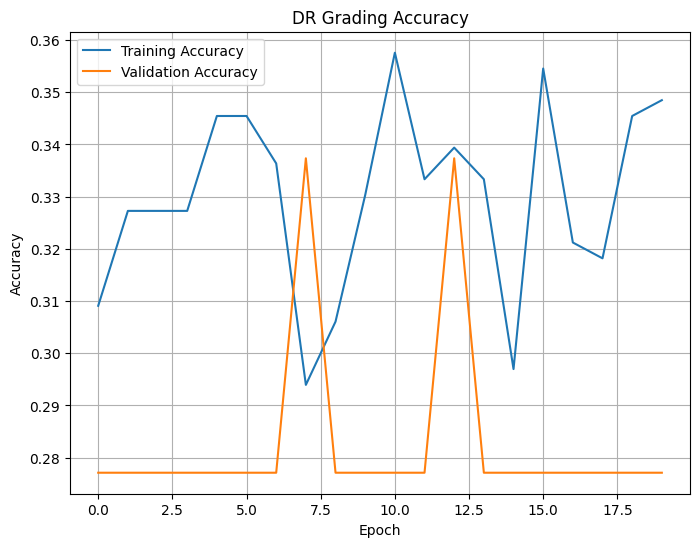

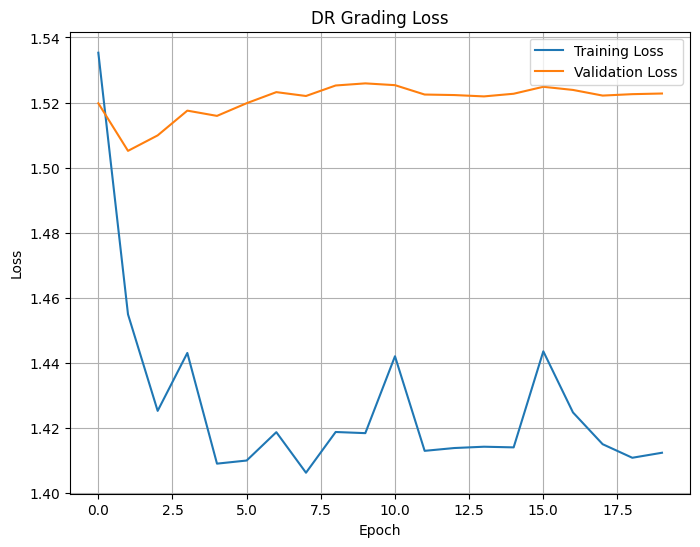

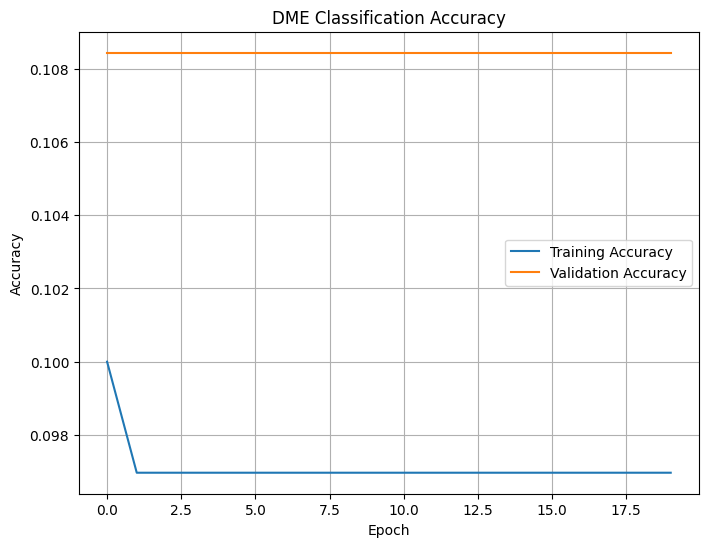

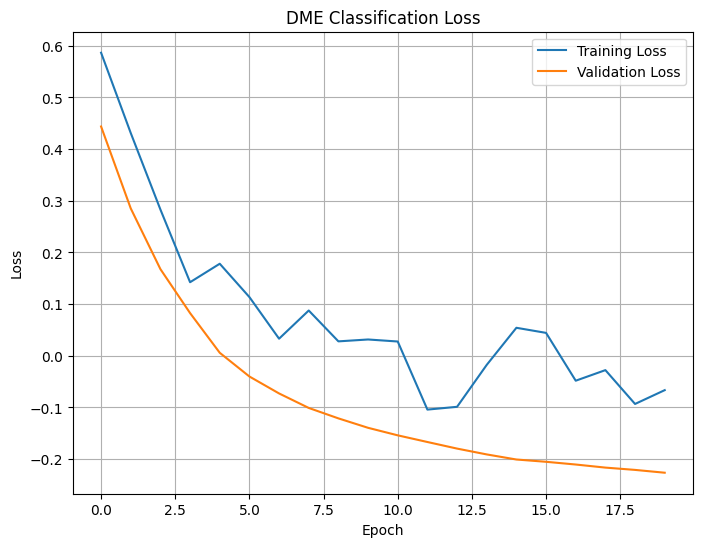

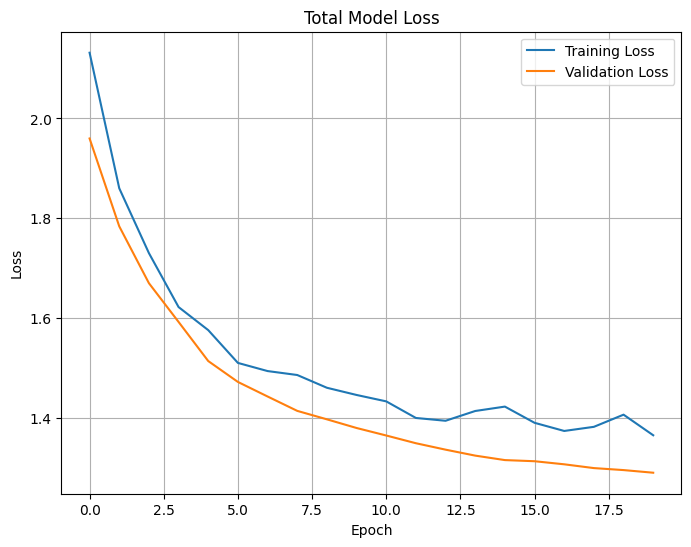

In [ ]:
# Create a directory to save the plots
output_dir = 'results'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Plot training & validation accuracy for DR grading
plt.figure(figsize=(8, 6))
plt.plot(history.history['dr_output_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_dr_output_accuracy'], label='Validation Accuracy')
plt.title('DR Grading Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'dr_grading_accuracy.png'))
plt.show()

# Plot training & validation loss for DR grading
plt.figure(figsize=(8, 6))
plt.plot(history.history['dr_output_loss'], label='Training Loss')
plt.plot(history.history['val_dr_output_loss'], label='Validation Loss')
plt.title('DR Grading Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'dr_grading_loss.png'))
plt.show()

# Plot training & validation accuracy for DME classification
plt.figure(figsize=(8, 6))
plt.plot(history.history['dme_output_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_dme_output_accuracy'], label='Validation Accuracy')
plt.title('DME Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'dme_classification_accuracy.png'))
plt.show()

# Plot training & validation loss for DME classification
plt.figure(figsize=(8, 6))
plt.plot(history.history['dme_output_loss'], label='Training Loss')
plt.plot(history.history['val_dme_output_loss'], label='Validation Loss')
plt.title('DME Classification Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'dme_classification_loss.png'))
plt.show()

# Plot total loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Total Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'total_model_loss.png'))
plt.show()


In [ ]:
# Save the trained model using the new Keras format
model.save('multi_output_dr_dme_model.keras')


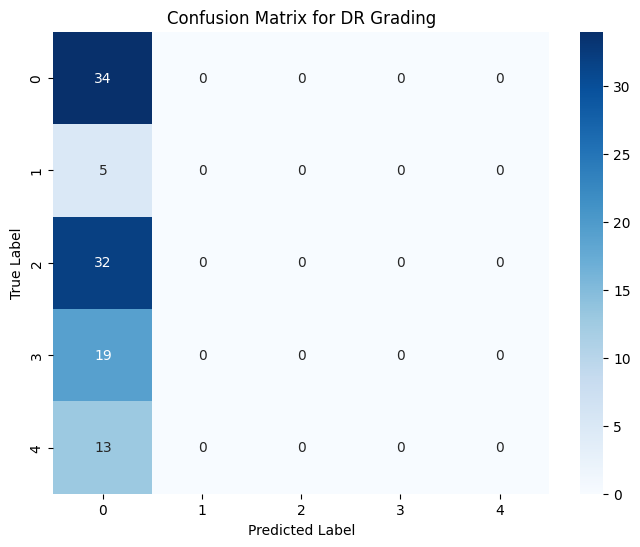

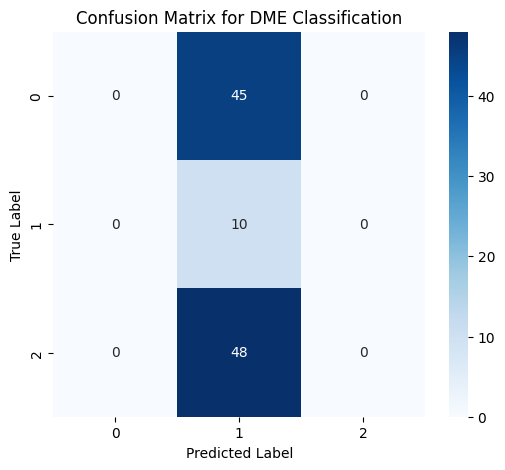

In [ ]:
# Confusion matrix for DR grading
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true_dr, y_pred_dr), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for DR Grading')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig(os.path.join(output_dir, 'confusion_matrix_dr_grading.png'))
plt.show()

# Confusion matrix for DME classification
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_true_dme, y_pred_dme), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for DME Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig(os.path.join(output_dir, 'confusion_matrix_dme_classification.png'))
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Ensure labels are numpy arrays of integers
y_true_dr = np.array(y_true_dr).astype(int)
y_pred_dr = np.array(y_pred_dr).astype(int)
y_true_dme = np.array(y_true_dme).astype(int)
y_pred_dme = np.array(y_pred_dme).astype(int)

# Metrics for DR grading (multi-class classification)
dr_precision = precision_score(y_true_dr, y_pred_dr, average='weighted', zero_division=0)
dr_recall = recall_score(y_true_dr, y_pred_dr, average='weighted', zero_division=0)
dr_f1 = f1_score(y_true_dr, y_pred_dr, average='weighted', zero_division=0)

print(f"DR Grading Precision: {dr_precision:.4f}")
print(f"DR Grading Recall: {dr_recall:.4f}")
print(f"DR Grading F1-Score: {dr_f1:.4f}")

# Check unique values in DME labels
print("Unique values in y_true_dme:", np.unique(y_true_dme))
print("Unique values in y_pred_dme:", np.unique(y_pred_dme))

# Determine if DME is binary or multiclass
if len(np.unique(y_true_dme)) > 2 or len(np.unique(y_pred_dme)) > 2:
    # Multiclass DME classification
    dme_precision = precision_score(y_true_dme, y_pred_dme, average='weighted', zero_division=0)
    dme_recall = recall_score(y_true_dme, y_pred_dme, average='weighted', zero_division=0)
    dme_f1 = f1_score(y_true_dme, y_pred_dme, average='weighted', zero_division=0)
else:
    # Binary DME classification
    dme_precision = precision_score(y_true_dme, y_pred_dme, average='binary', pos_label=1, zero_division=0)
    dme_recall = recall_score(y_true_dme, y_pred_dme, average='binary', pos_label=1, zero_division=0)
    dme_f1 = f1_score(y_true_dme, y_pred_dme, average='binary', pos_label=1, zero_division=0)

print(f"DME Classification Precision: {dme_precision:.4f}")
print(f"DME Classification Recall: {dme_recall:.4f}")
print(f"DME Classification F1-Score: {dme_f1:.4f}")


DR Grading Precision: 0.1090
DR Grading Recall: 0.3301
DR Grading F1-Score: 0.1638
Unique values in y_true_dme: [0 1 2]
Unique values in y_pred_dme: [1]
DME Classification Precision: 0.0094
DME Classification Recall: 0.0971
DME Classification F1-Score: 0.0172


In [ ]:
# Save evaluation metrics to a text file
with open(os.path.join(output_dir, 'evaluation_metrics.txt'), 'w') as f:
    f.write("Evaluation Metrics for Multi-Output DR Grading and DME Classification Model\n\n")

    f.write("Diabetic Retinopathy (DR) Grading Metrics:\n")
    f.write(f"Precision: {dr_precision:.4f}\n")
    f.write(f"Recall: {dr_recall:.4f}\n")
    f.write(f"F1-Score: {dr_f1:.4f}\n\n")

    f.write("Diabetic Macular Edema (DME) Classification Metrics:\n")
    f.write(f"Precision: {dme_precision:.4f}\n")
    f.write(f"Recall: {dme_recall:.4f}\n")
    f.write(f"F1-Score: {dme_f1:.4f}\n")
